<a href="https://colab.research.google.com/github/ISE-CS4445-AI/challenge-6-tomjoyce1/blob/main/challenge-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge #6: Reducing Overfitting with Regularization (FashionMNIST)

**Instructions**:
- This challenge builds on **Week 6**’s regularization lessons: **data augmentation**, **dropout**, and **weight decay**.
- We demonstrate a baseline CNN on **FashionMNIST** that clearly overfits. Then we apply these techniques to see the improvement.

**Scoring**:  9 points total. Fill in the `# TODO` placeholders and fill in the final reflection markdown cell. **There is no autograder** for this assignment. If your code works without errors and achieves the objectives of reducing overfitting by the end of this challenge, you will have done well. 👍

We’ll use the **FashionMNIST** dataset, which consists of 60,000 training images and 10,000 test images of 28x28 grayscale images of 10 different fashion categories. By applying these techniques, we aim to reduce overfitting and improve robust performance.

---

## Imports & Setup

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


### Utility functions

Defining the utility function to plot metrics below.

In [69]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot.
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005

        plt.plot(X, y, label=label, marker=marker)

        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

## Task 1: getTransforms(augmentation=False) <font color='green'>(1 point)</font>

**Goal**: Return a **train_transform** and a **test_transform**.  
- If `augmentation=True`, apply random transformations. Otherwise just basic.  
- *FashionMNIST* is 28×28 grayscale, so consider **random horizontal flip** or **random rotation**. Keep it simple.

In [70]:
def getTransforms(augmentation=False):
    # mean,std for FashionMNIST (approx)
    mean = (0.2860,)
    std = (0.3530,)

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])


    if augmentation:
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        return train_transform, test_transform

    return test_transform, test_transform


## Task 2: create the dataloaders <font color='green'>(1 point)</font>

In [71]:
def load_fashionMNIST_data(batch_size=64, augmentation=False):
    """
    Return train_loader and test_loader
    """

    # Apply augmentation if specified
    train_transform, test_transform = getTransforms(augmentation)

    # Download the FashionMNIST dataset with respective transformations
    train_dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=train_transform)
    test_dataset  = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=test_transform)

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Applying Data Augmentation
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)
print("Train set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))


Train set size: 60000
Test set size: 60000


## Task 3: Define a CNN with Dropout  <font color='green'>(2 points)</font>

**Task**:  
- Build a small **CNN** with a few convolution layers, each followed by ReLU & maxpool.  
- Insert **dropout** layers (e.g., `nn.Dropout(0.3)`) to help reduce overfitting.  
- The final linear outputs 10 classes.  
- We'll call it `NetFashion`.

In [72]:
class NetFashion(nn.Module):
    def __init__(self, dropout_prob=0.3, useRegularization=False):
        super().__init__()
        self.useRegularization = useRegularization

        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # If regularization is applied, we use dropout
        if self.useRegularization:
            self.dropout = nn.Dropout(dropout_prob)

        # Additional convolutional layers
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        if self.useRegularization:
            x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        out = self.fc2(x)

        return out


## Training Loop

Below is a standard training loop with helper train and test methods defined which should look familiar by now. :)

In [73]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimiser.zero_grad()

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimiser.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimiser, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in tqdm(range(epochs), desc="Epochs"):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimiser)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

## Task 4: Evaluate & Check Test Accuracy

**Task**:  
1. Measure train and test metrics for non-regularised model with non-augmented data.  
2. Do the same train and test loop for your regularised model on augmented data with weight decay in the optimiser and observe the difference.
   1. However, apply all the different techniques individually.
   2. Run the code cells to plot metrics after each experiment

### Task 4.1: Non-regularised model with non-augmented data  <font color='green'>(1 point)</font>

In [74]:
model = NetFashion().to(device) # Getting the Fashion MNIST model

# TODO: Define the loss function and the optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

In [75]:
epochs = 5
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:

loss: 2.305475  [   64/60000]
loss: 0.958375  [ 6464/60000]
loss: 0.609001  [12864/60000]
loss: 0.620639  [19264/60000]
loss: 0.472590  [25664/60000]
loss: 0.484805  [32064/60000]
loss: 0.401191  [38464/60000]
loss: 0.368784  [44864/60000]
loss: 0.236765  [51264/60000]
loss: 0.481185  [57664/60000]


Epochs:  20%|██        | 1/5 [01:06<04:24, 66.16s/it]

Train Error: 
 Accuracy: 85.1%, Avg loss: 0.402836 

Test Error: 
 Accuracy: 87.4%, Avg loss: 0.340539 

Epoch 2:

loss: 0.474143  [   64/60000]
loss: 0.546199  [ 6464/60000]
loss: 0.276065  [12864/60000]
loss: 0.342440  [19264/60000]
loss: 0.478773  [25664/60000]
loss: 0.217041  [32064/60000]
loss: 0.314665  [38464/60000]
loss: 0.423371  [44864/60000]
loss: 0.401227  [51264/60000]
loss: 0.343217  [57664/60000]


Epochs:  40%|████      | 2/5 [02:12<03:18, 66.03s/it]

Train Error: 
 Accuracy: 87.5%, Avg loss: 0.336163 

Test Error: 
 Accuracy: 89.7%, Avg loss: 0.275471 

Epoch 3:

loss: 0.628306  [   64/60000]
loss: 0.223127  [ 6464/60000]
loss: 0.363676  [12864/60000]
loss: 0.344523  [19264/60000]
loss: 0.432204  [25664/60000]
loss: 0.352482  [32064/60000]
loss: 0.295294  [38464/60000]
loss: 0.339392  [44864/60000]
loss: 0.217916  [51264/60000]
loss: 0.211357  [57664/60000]


Epochs:  60%|██████    | 3/5 [03:18<02:12, 66.04s/it]

Train Error: 
 Accuracy: 89.8%, Avg loss: 0.280576 

Test Error: 
 Accuracy: 91.4%, Avg loss: 0.231042 

Epoch 4:

loss: 0.220364  [   64/60000]
loss: 0.460263  [ 6464/60000]
loss: 0.291244  [12864/60000]
loss: 0.175977  [19264/60000]
loss: 0.211326  [25664/60000]
loss: 0.235108  [32064/60000]
loss: 0.228271  [38464/60000]
loss: 0.425062  [44864/60000]
loss: 0.318477  [51264/60000]
loss: 0.170617  [57664/60000]


Epochs:  80%|████████  | 4/5 [04:23<01:05, 65.66s/it]

Train Error: 
 Accuracy: 91.0%, Avg loss: 0.245342 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.201157 

Epoch 5:

loss: 0.340208  [   64/60000]
loss: 0.207622  [ 6464/60000]
loss: 0.408386  [12864/60000]
loss: 0.394636  [19264/60000]
loss: 0.191570  [25664/60000]
loss: 0.199121  [32064/60000]
loss: 0.258619  [38464/60000]
loss: 0.165698  [44864/60000]
loss: 0.419178  [51264/60000]
loss: 0.327365  [57664/60000]


Epochs: 100%|██████████| 5/5 [05:29<00:00, 65.80s/it]

Train Error: 
 Accuracy: 90.7%, Avg loss: 0.252148 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.204473 

Done training!


Plotting metrics

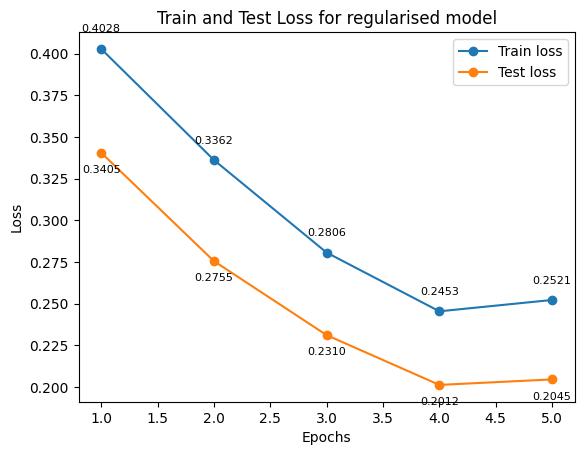

In [76]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.01}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.012})]
plotTitle = 'Train and Test Loss for regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

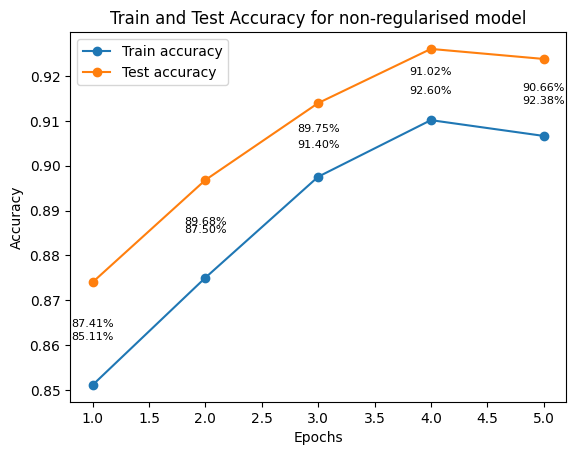

In [77]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.01,
                                      'decimalPlaces': 2, 'displayPercent': True}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.01,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for non-regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Task 4.2: With regularisation and data augmentation applied <font color='green'>(3 points)</font>
Train and test the same model with different regularisation techniques applied where you apply them one at a time

only data augmentation


In [78]:
# Apply only data augmentation

# NO REGULARISATION LIKE WEIGHT DECAY HERE


train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)

# Define model with regularization (Dropout)
model = NetFashion(dropout_prob=0.3, useRegularization=True).to(device)

epochs = 5 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = optim.Adam(model.parameters(), lr=0.001)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:

loss: 2.303537  [   64/60000]
loss: 1.016428  [ 6464/60000]
loss: 0.507441  [12864/60000]
loss: 0.671819  [19264/60000]
loss: 0.465331  [25664/60000]
loss: 0.469034  [32064/60000]
loss: 0.497235  [38464/60000]
loss: 0.478829  [44864/60000]
loss: 0.476301  [51264/60000]
loss: 0.366110  [57664/60000]


Epochs:  20%|██        | 1/5 [01:06<04:26, 66.66s/it]

Train Error: 
 Accuracy: 84.4%, Avg loss: 0.408415 

Test Error: 
 Accuracy: 86.2%, Avg loss: 0.360718 

Epoch 2:

loss: 0.334222  [   64/60000]
loss: 0.331961  [ 6464/60000]
loss: 0.366450  [12864/60000]
loss: 0.495706  [19264/60000]
loss: 0.364155  [25664/60000]
loss: 0.230953  [32064/60000]
loss: 0.395449  [38464/60000]
loss: 0.511814  [44864/60000]
loss: 0.311207  [51264/60000]
loss: 0.593127  [57664/60000]


Epochs:  40%|████      | 2/5 [02:13<03:20, 66.95s/it]

Train Error: 
 Accuracy: 86.6%, Avg loss: 0.357457 

Test Error: 
 Accuracy: 87.9%, Avg loss: 0.315279 

Epoch 3:

loss: 0.333763  [   64/60000]
loss: 0.390449  [ 6464/60000]
loss: 0.169789  [12864/60000]
loss: 0.226910  [19264/60000]
loss: 0.425232  [25664/60000]
loss: 0.257630  [32064/60000]
loss: 0.409230  [38464/60000]
loss: 0.312794  [44864/60000]
loss: 0.374533  [51264/60000]
loss: 0.321028  [57664/60000]


Epochs:  60%|██████    | 3/5 [03:20<02:13, 66.85s/it]

Train Error: 
 Accuracy: 89.2%, Avg loss: 0.296674 

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.248711 

Epoch 4:

loss: 0.244875  [   64/60000]
loss: 0.268418  [ 6464/60000]
loss: 0.326652  [12864/60000]
loss: 0.232106  [19264/60000]
loss: 0.170698  [25664/60000]
loss: 0.153622  [32064/60000]
loss: 0.242524  [38464/60000]
loss: 0.262300  [44864/60000]
loss: 0.239707  [51264/60000]
loss: 0.336865  [57664/60000]


Epochs:  80%|████████  | 4/5 [04:27<01:06, 66.77s/it]

Train Error: 
 Accuracy: 90.0%, Avg loss: 0.270762 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.224173 

Epoch 5:

loss: 0.189426  [   64/60000]
loss: 0.193492  [ 6464/60000]
loss: 0.164770  [12864/60000]
loss: 0.289257  [19264/60000]
loss: 0.408845  [25664/60000]
loss: 0.335984  [32064/60000]
loss: 0.486297  [38464/60000]
loss: 0.253175  [44864/60000]
loss: 0.224805  [51264/60000]
loss: 0.239169  [57664/60000]


Epochs: 100%|██████████| 5/5 [05:34<00:00, 66.98s/it]

Train Error: 
 Accuracy: 90.9%, Avg loss: 0.242242 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.195467 

Done training!


Plotting metrics

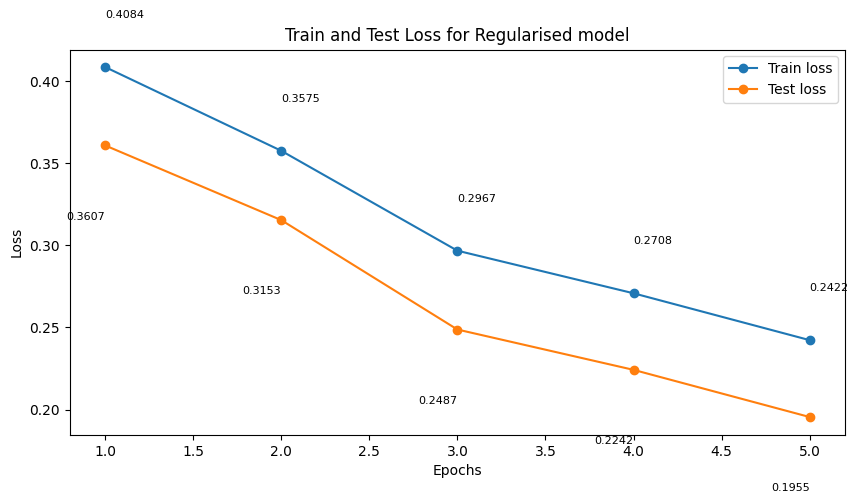

In [79]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

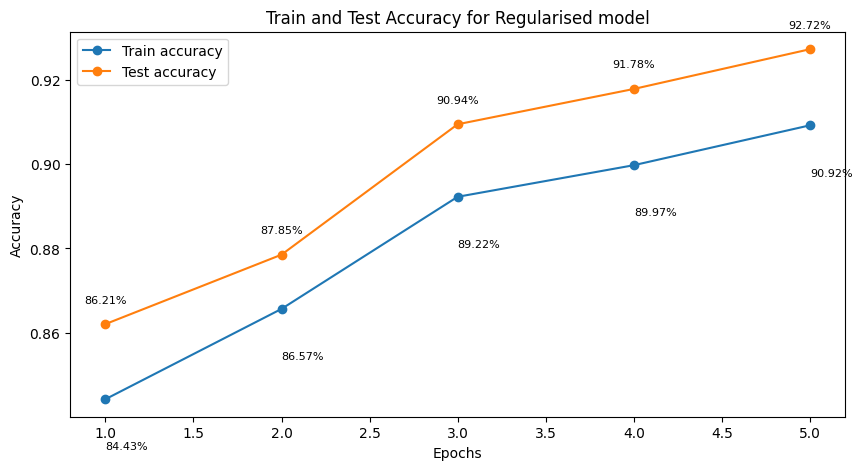

In [80]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

only regularisation


In [81]:
# Apply only regularisation on the cnn model

# NO AUGMENTATION HERE ONLY REGULARISATION


train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

model = NetFashion(dropout_prob=0.3, useRegularization=True).to(device)

epochs = 5 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = optim.Adam(model.parameters(), lr=0.001)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:

loss: 2.302834  [   64/60000]
loss: 0.502932  [ 6464/60000]
loss: 0.250625  [12864/60000]
loss: 0.453527  [19264/60000]
loss: 0.369639  [25664/60000]
loss: 0.305985  [32064/60000]
loss: 0.246754  [38464/60000]
loss: 0.288286  [44864/60000]
loss: 0.243553  [51264/60000]
loss: 0.205632  [57664/60000]


Epochs:  20%|██        | 1/5 [00:43<02:55, 43.91s/it]

Train Error: 
 Accuracy: 91.0%, Avg loss: 0.241624 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.241696 

Epoch 2:

loss: 0.142084  [   64/60000]
loss: 0.330759  [ 6464/60000]
loss: 0.257904  [12864/60000]
loss: 0.172358  [19264/60000]
loss: 0.259364  [25664/60000]
loss: 0.269807  [32064/60000]
loss: 0.114080  [38464/60000]
loss: 0.349229  [44864/60000]
loss: 0.367050  [51264/60000]
loss: 0.519117  [57664/60000]


Epochs:  40%|████      | 2/5 [01:27<02:11, 43.72s/it]

Train Error: 
 Accuracy: 93.2%, Avg loss: 0.180768 

Test Error: 
 Accuracy: 93.2%, Avg loss: 0.180771 

Epoch 3:

loss: 0.161113  [   64/60000]
loss: 0.189776  [ 6464/60000]
loss: 0.200874  [12864/60000]
loss: 0.150905  [19264/60000]
loss: 0.263197  [25664/60000]
loss: 0.103322  [32064/60000]
loss: 0.160753  [38464/60000]
loss: 0.145413  [44864/60000]
loss: 0.263874  [51264/60000]
loss: 0.294769  [57664/60000]


Epochs:  60%|██████    | 3/5 [02:10<01:26, 43.45s/it]

Train Error: 
 Accuracy: 94.6%, Avg loss: 0.149918 

Test Error: 
 Accuracy: 94.6%, Avg loss: 0.149981 

Epoch 4:

loss: 0.227278  [   64/60000]
loss: 0.109057  [ 6464/60000]
loss: 0.255968  [12864/60000]
loss: 0.189832  [19264/60000]
loss: 0.185978  [25664/60000]
loss: 0.167370  [32064/60000]
loss: 0.233354  [38464/60000]
loss: 0.158425  [44864/60000]
loss: 0.141138  [51264/60000]
loss: 0.185512  [57664/60000]


Epochs:  80%|████████  | 4/5 [02:53<00:43, 43.41s/it]

Train Error: 
 Accuracy: 95.6%, Avg loss: 0.123600 

Test Error: 
 Accuracy: 95.6%, Avg loss: 0.123605 

Epoch 5:

loss: 0.091399  [   64/60000]
loss: 0.152217  [ 6464/60000]
loss: 0.223799  [12864/60000]
loss: 0.149766  [19264/60000]
loss: 0.071385  [25664/60000]
loss: 0.079233  [32064/60000]
loss: 0.083019  [38464/60000]
loss: 0.060017  [44864/60000]
loss: 0.141793  [51264/60000]
loss: 0.081901  [57664/60000]


Epochs: 100%|██████████| 5/5 [03:38<00:00, 43.77s/it]

Train Error: 
 Accuracy: 96.4%, Avg loss: 0.096694 

Test Error: 
 Accuracy: 96.4%, Avg loss: 0.096709 

Done training!


Plotting metrics

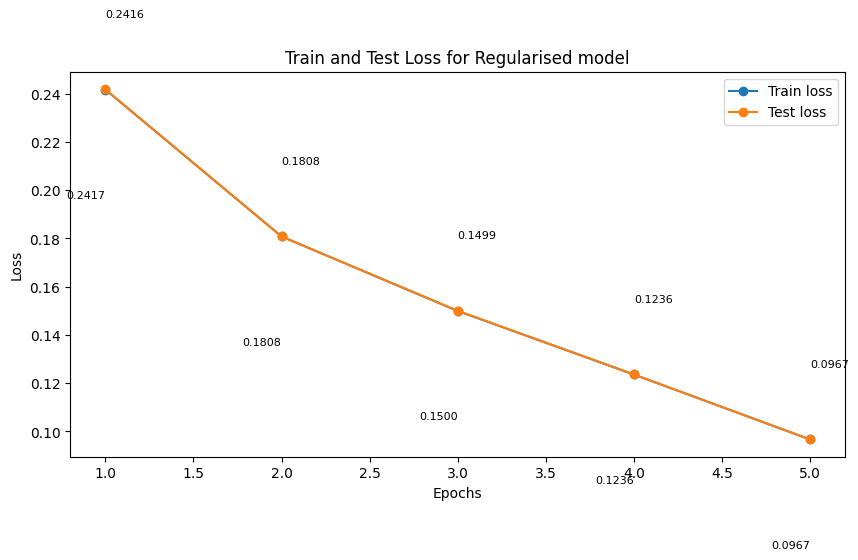

In [82]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

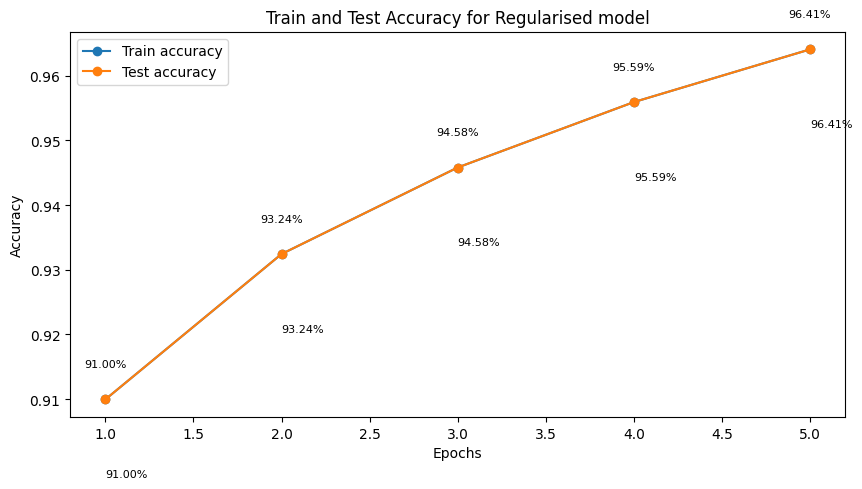

In [83]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

only weight decay below


In [ ]:

# Apply only weight decay technique, no aug or dropout
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

model = NetFashion(dropout_prob=0.3, useRegularization=False).to(device)
epochs = 5 # Increasing the number of epochs by 5 since the learning will be more gradual.


# Define the optimizer with weight decay (no dropout, no augmentation)
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Apply weight decay (L2 regularization)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:

loss: 2.298679  [   64/60000]
loss: 0.529984  [ 6464/60000]
loss: 0.439098  [12864/60000]
loss: 0.380149  [19264/60000]
loss: 0.333705  [25664/60000]
loss: 0.344063  [32064/60000]
loss: 0.433873  [38464/60000]
loss: 0.152367  [44864/60000]
loss: 0.185441  [51264/60000]
loss: 0.230488  [57664/60000]


Epochs:  20%|██        | 1/5 [00:44<02:56, 44.04s/it]

Train Error: 
 Accuracy: 91.2%, Avg loss: 0.245313 

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.245235 

Epoch 2:

loss: 0.351387  [   64/60000]
loss: 0.134720  [ 6464/60000]
loss: 0.121917  [12864/60000]
loss: 0.126214  [19264/60000]
loss: 0.292847  [25664/60000]
loss: 0.254390  [32064/60000]
loss: 0.228384  [38464/60000]
loss: 0.197737  [44864/60000]
loss: 0.214202  [51264/60000]
loss: 0.287677  [57664/60000]


Epochs:  40%|████      | 2/5 [01:28<02:12, 44.24s/it]

Train Error: 
 Accuracy: 93.8%, Avg loss: 0.173683 

Test Error: 
 Accuracy: 93.8%, Avg loss: 0.173605 

Epoch 3:

loss: 0.243103  [   64/60000]
loss: 0.283009  [ 6464/60000]
loss: 0.174465  [12864/60000]
loss: 0.174836  [19264/60000]
loss: 0.119793  [25664/60000]
loss: 0.149652  [32064/60000]
loss: 0.141603  [38464/60000]
loss: 0.254325  [44864/60000]
loss: 0.188560  [51264/60000]
loss: 0.192791  [57664/60000]


Epochs:  60%|██████    | 3/5 [02:13<01:29, 44.71s/it]

Train Error: 
 Accuracy: 93.8%, Avg loss: 0.161358 

Test Error: 
 Accuracy: 93.8%, Avg loss: 0.161261 

Epoch 4:

loss: 0.121181  [   64/60000]
loss: 0.130884  [ 6464/60000]
loss: 0.179464  [12864/60000]
loss: 0.164580  [19264/60000]
loss: 0.201585  [25664/60000]
loss: 0.258669  [32064/60000]
loss: 0.242708  [38464/60000]
loss: 0.112425  [44864/60000]
loss: 0.071509  [51264/60000]
loss: 0.238672  [57664/60000]


Epochs:  80%|████████  | 4/5 [02:56<00:44, 44.11s/it]

Train Error: 
 Accuracy: 95.5%, Avg loss: 0.122184 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.122164 

Epoch 5:

loss: 0.184938  [   64/60000]
loss: 0.079895  [ 6464/60000]
loss: 0.142972  [12864/60000]
loss: 0.244322  [19264/60000]
loss: 0.131006  [25664/60000]
loss: 0.044927  [32064/60000]
loss: 0.151267  [38464/60000]
loss: 0.240706  [44864/60000]


Plotting metrics

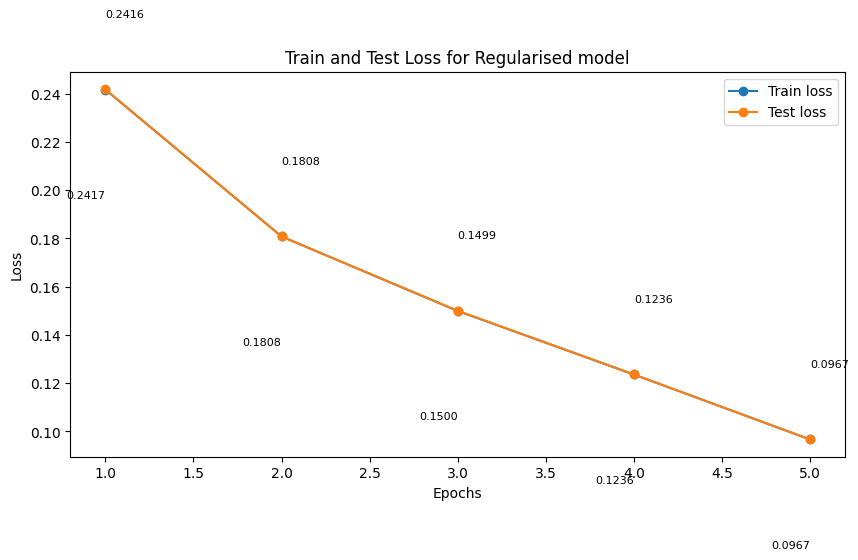

In [84]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

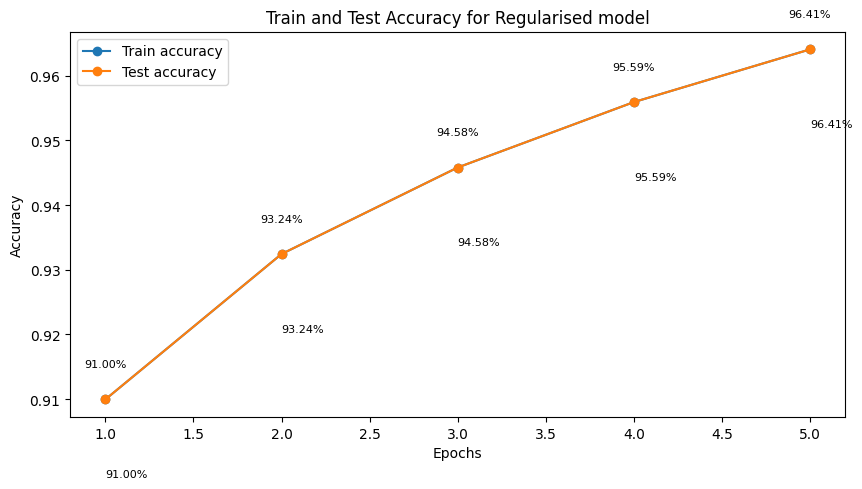

In [85]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

Apply all the regularisation techniques together below

In [67]:
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)
model = NetFashion(dropout_prob=0.3, useRegularization=True).to(device)
epochs = 5
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:

loss: 2.300087  [   64/60000]
loss: 1.106262  [ 6464/60000]
loss: 0.680833  [12864/60000]
loss: 0.537656  [19264/60000]
loss: 0.578222  [25664/60000]
loss: 0.550367  [32064/60000]
loss: 0.457344  [38464/60000]
loss: 0.375692  [44864/60000]
loss: 0.517681  [51264/60000]
loss: 0.362628  [57664/60000]


Epochs:  20%|██        | 1/5 [01:07<04:31, 67.82s/it]

Train Error: 
 Accuracy: 83.3%, Avg loss: 0.445378 

Test Error: 
 Accuracy: 86.3%, Avg loss: 0.371947 

Epoch 2:

loss: 0.513455  [   64/60000]
loss: 0.544826  [ 6464/60000]
loss: 0.521806  [12864/60000]
loss: 0.441276  [19264/60000]
loss: 0.535316  [25664/60000]
loss: 0.418788  [32064/60000]
loss: 0.318866  [38464/60000]
loss: 0.368255  [44864/60000]
loss: 0.461983  [51264/60000]
loss: 0.751041  [57664/60000]


Epochs:  40%|████      | 2/5 [02:13<03:19, 66.64s/it]

Train Error: 
 Accuracy: 86.3%, Avg loss: 0.372729 

Test Error: 
 Accuracy: 88.3%, Avg loss: 0.313823 

Epoch 3:

loss: 0.680355  [   64/60000]
loss: 0.217697  [ 6464/60000]
loss: 0.379056  [12864/60000]
loss: 0.255078  [19264/60000]
loss: 0.311039  [25664/60000]
loss: 0.344168  [32064/60000]
loss: 0.305334  [38464/60000]
loss: 0.269040  [44864/60000]
loss: 0.376395  [51264/60000]
loss: 0.218973  [57664/60000]


Epochs:  60%|██████    | 3/5 [03:19<02:12, 66.41s/it]

Train Error: 
 Accuracy: 88.9%, Avg loss: 0.305195 

Test Error: 
 Accuracy: 90.7%, Avg loss: 0.252814 

Epoch 4:

loss: 0.102837  [   64/60000]
loss: 0.374595  [ 6464/60000]
loss: 0.359277  [12864/60000]
loss: 0.322337  [19264/60000]
loss: 0.289020  [25664/60000]
loss: 0.269982  [32064/60000]
loss: 0.334609  [38464/60000]
loss: 0.256771  [44864/60000]
loss: 0.352289  [51264/60000]
loss: 0.104326  [57664/60000]


Epochs:  80%|████████  | 4/5 [04:25<01:05, 65.98s/it]

Train Error: 
 Accuracy: 88.7%, Avg loss: 0.302064 

Test Error: 
 Accuracy: 90.4%, Avg loss: 0.251614 

Epoch 5:

loss: 0.333127  [   64/60000]
loss: 0.344740  [ 6464/60000]
loss: 0.272159  [12864/60000]
loss: 0.520429  [19264/60000]
loss: 0.267002  [25664/60000]
loss: 0.213438  [32064/60000]
loss: 0.327396  [38464/60000]
loss: 0.377099  [44864/60000]
loss: 0.309336  [51264/60000]
loss: 0.514370  [57664/60000]


Epochs: 100%|██████████| 5/5 [05:30<00:00, 66.13s/it]

Train Error: 
 Accuracy: 89.9%, Avg loss: 0.280415 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.217367 

Done training!


Plotting metrics

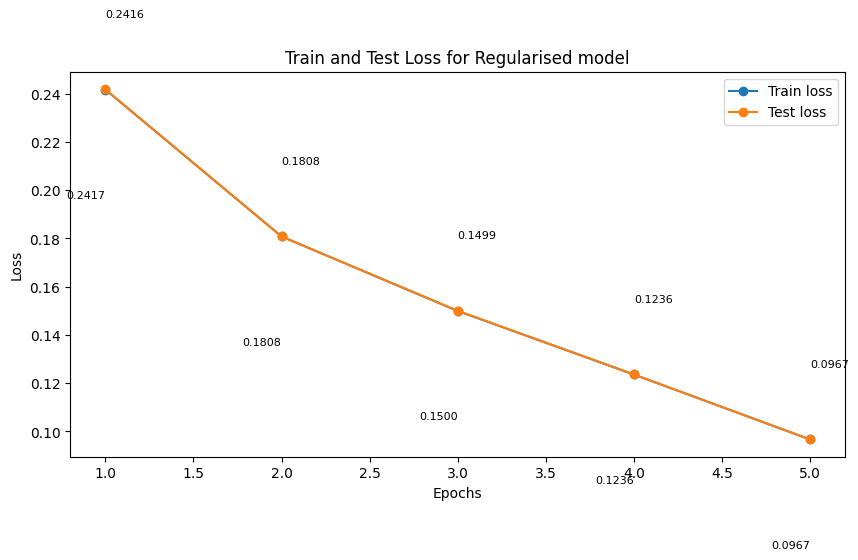

In [86]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

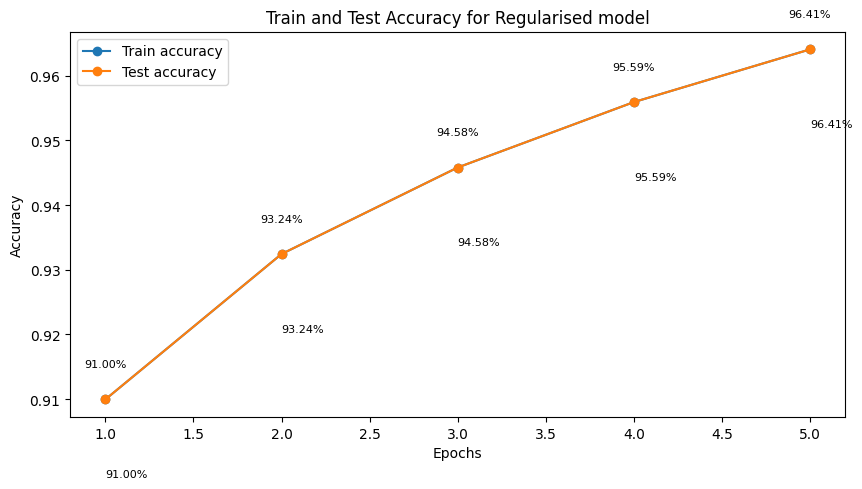

In [87]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

## Reflection <font color='green'>(1 point)</font>
Write your thoughts and observations about overfitting and the techniques used above to reduce them in brief.

<font color='red'>Regularisation is a good technique because it prevents the model from becoming too complex and overfitting, by adding a penalty for complexity.  Weight decay stops the model from being too reliant on certain features or parameters. Data augmentation creates more variation in the training data, enabling it to generalise btter. I didn't achieve better accuracy results with both regularisation and augmentation techniques applied, although there was less difference between train and test accuracy.</font>

